In [ ]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import Image
from matplotlib import gridspec

df2 = pd.read_csv('BattingAverage.csv', usecols=[0,1,2,3], dtype={'PriPos':'category'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Player  948 non-null    object  
 1   PriPos  948 non-null    category
 2   Hits    948 non-null    int64   
 3   AtBats  948 non-null    int64   
dtypes: category(1), int64(2), object(1)
memory usage: 23.7+ KB


# 新增區段

In [ ]:
df2['BatAv'] = df2.Hits.divide(df2.AtBats)
df2.head(10)

,Player,PriPos,Hits,AtBats,BatAv
0,Fernando Abad,Pitcher,1,7,0.142857
1,Bobby Abreu,Left Field,53,219,0.242009
2,Tony Abreu,2nd Base,18,70,0.257143
3,Dustin Ackley,2nd Base,137,607,0.225700
4,Matt Adams,1st Base,21,86,0.244186
5,Nathan Adcock,Pitcher,0,1,0.000000
6,Jeremy Affeldt,Pitcher,0,1,0.000000
7,Brandon Allen,1st Base,2,20,0.100000
8,Yonder Alonso,1st Base,150,549,0.273224
9,Jose Altuve,2nd Base,167,576,0.289931


In [ ]:
# Batting average by primary field positions calculated from the data
df2.groupby('PriPos')['Hits','AtBats'].sum().pipe(lambda x: x.Hits/x.AtBats)

PriPos
1st Base        0.258851
2nd Base        0.255676
3rd Base        0.265036
Catcher         0.247404
Center Field    0.263513
Left Field      0.259077
Pitcher         0.129148
Right Field     0.263555
Shortstop       0.255186
dtype: float64

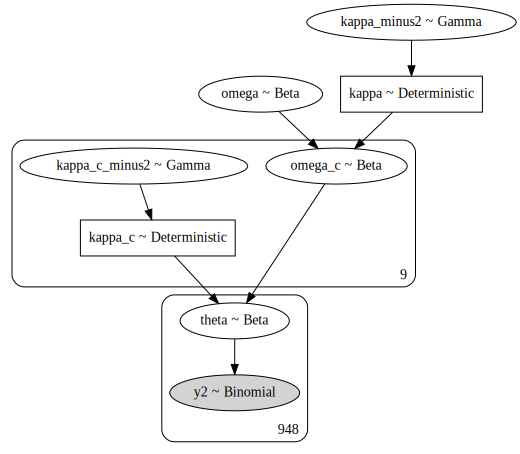

In [ ]:
pripos_idx = df2.PriPos.cat.codes.values
pripos_codes = df2.PriPos.cat.categories
n_pripos = pripos_codes.size

# df2 contains one entry per player
n_players = df2.index.size

with pm.Model() as hierarchical_model2:
    # Hyper parameters
    omega = pm.Beta('omega', 1, 1)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    # Parameters for categories (Primary field positions)
    omega_c = pm.Beta('omega_c',
                       omega*(kappa-2)+1, (1-omega)*(kappa-2)+1,
                       shape = n_pripos)
    
    kappa_c_minus2 = pm.Gamma('kappa_c_minus2',
                              0.01, 0.01,
                              shape = n_pripos)
    kappa_c = pm.Deterministic('kappa_c', kappa_c_minus2 + 2)
        
    # Parameter for individual players
    theta = pm.Beta('theta',
                     omega_c[pripos_idx]*(kappa_c[pripos_idx]-2)+1,
                    (1-omega_c[pripos_idx])*(kappa_c[pripos_idx]-2)+1,
                     shape = n_players)
    
    y2 = pm.Binomial('y2', n=df2.AtBats.values, p=theta, observed=df2.Hits)

pm.model_to_graphviz(hierarchical_model2)

In [ ]:
with hierarchical_model2:
    trace2 = pm.sample(5000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, kappa_c_minus2, omega_c, kappa_minus2, omega]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [05:08<00:00, 71.41draws/s]
The number of effective samples is smaller than 10% for some parameters.


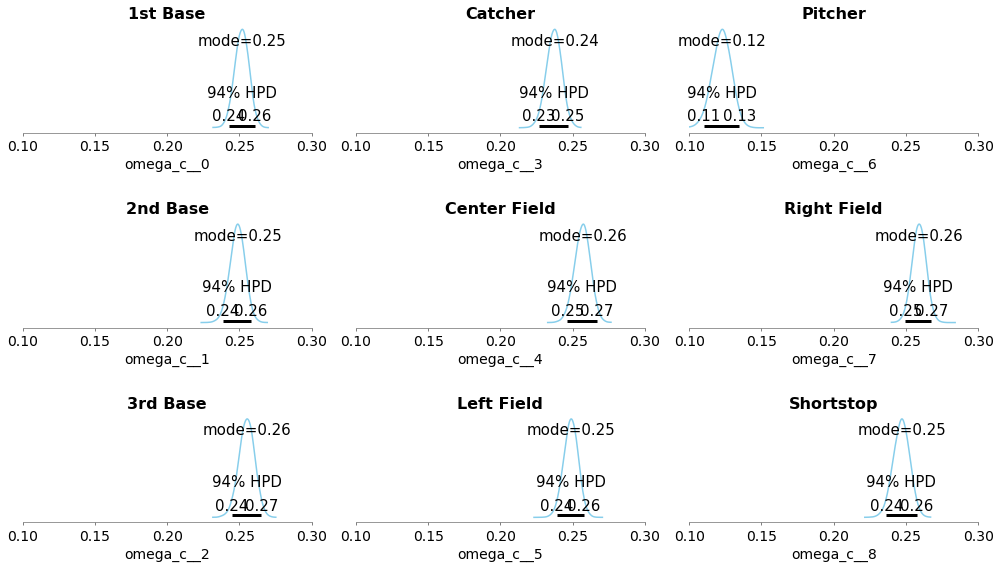

In [ ]:
color = '#87ceeb'
fig, axes = plt.subplots(3,3, figsize=(14,8))

for i, ax in enumerate(axes.T.flatten()):
    pm.plot_posterior(trace2['omega_c'][:,i], ax=ax, point_estimate='mode', color=color)
    ax.set_title(pripos_codes[i], fontdict={'fontsize':16, 'fontweight':'bold'})
    ax.set_xlabel('omega_c__{}'.format(i), fontdict={'fontsize':14})
    ax.set_xlim(0.10,0.30)

plt.tight_layout(h_pad=3)

In [ ]:
pripos_codes[0]
df2.Player.to_list().index('Kyle Blanks')
# trace2.theta[df2.Player.to_list().index('Kyle Blanks')]

74

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa54c064d30>],
      dtype=object)

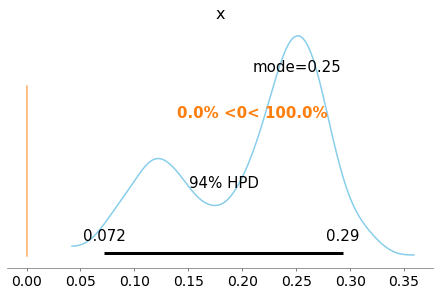

In [ ]:
#Kyle Blanks vs Bruce Chen
means_diff = trace2.theta[df2.Player.to_list().index('Kyle Blanks')] - trace2.theta[df2.Player.to_list().index('Bruce Chen')]
pm.plot_posterior( trace2.theta[df2.Player.to_list().index('Kyle Blanks')] , point_estimate='mode', color=color,ref_val=0)
# pm.plot_posterior(means_diff, ref_val=0)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa54ca1aa90>],
      dtype=object)

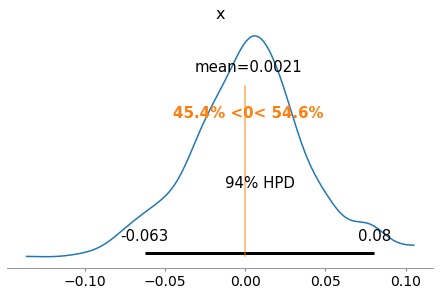

In [ ]:
#ShinSoo Choo vs Ichiro Suzuki
means_diff = trace2.theta[df2.Player.to_list().index('ShinSoo Choo')] - trace2.theta[df2.Player.to_list().index('Ichiro Suzuki')]
pm.plot_posterior(means_diff, ref_val=0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa56412b208>],
      dtype=object)

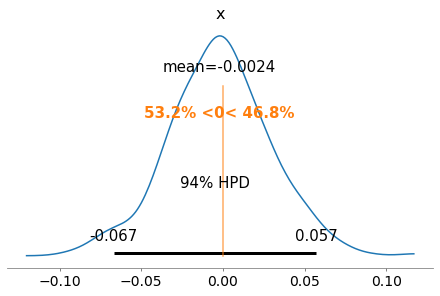

In [ ]:
#Mike Leake vs Wandy Rodriguez
means_diff = trace2.theta[df2.Player.to_list().index('Mike Leake')] - trace2.theta[df2.Player.to_list().index('Wandy Rodriguez')]
pm.plot_posterior(means_diff, ref_val=0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa562d83240>],
      dtype=object)

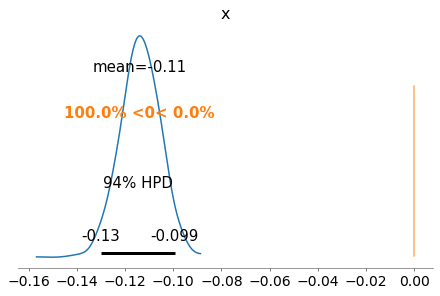

In [ ]:
# import Arviz as az
means_diff = trace2['omega_c'][:,6] - trace2['omega_c'][:,3]
pm.plot_posterior(means_diff, ref_val=0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa556ab9908>],
      dtype=object)

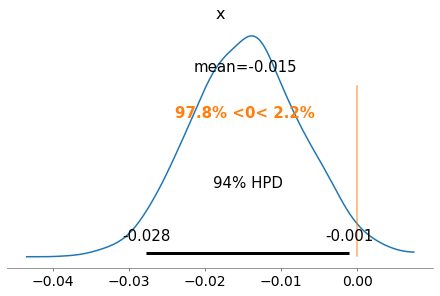

In [ ]:
# import Arviz as az
means_diff = trace2['omega_c'][:,3] - trace2['omega_c'][:,0]
pm.plot_posterior(means_diff, ref_val=0)

In [ ]:
df2.Player.to_list().index('Fernando Abad')

means_diff = trace2['omega_c'][:,3] - trace2['omega_c'][:,0]
pm.plot_posterior(means_diff, ref_val=0)

In [ ]:
theta[0][:]

IndexError: ignored

In [ ]:
trace2['omega_c'].shape

(2000, 9)